In [4]:
from transformers import AutoProcessor, AutoModelForImageTextToText,AutoModelForCausalLM,AutoTokenizer
from transformers.image_utils import load_image
from transformers import AutoTokenizer
from PIL import Image
import torch

In [3]:
# Load model and processor
model_id_vlm = "LiquidAI/LFM2-VL-450M"
model_vlm = AutoModelForImageTextToText.from_pretrained(
    model_id_vlm,
    device_map={"": "cpu"},  # force CPU
    torch_dtype="float32",   # safer on CPU
    trust_remote_code=True
)
processor_vlm = AutoProcessor.from_pretrained(model_id_vlm, trust_remote_code=True)

# ===== LOAD TEST IMAGE =====
# image_path = "./detected/003843_detections.jpg"
image_path = "data/dg.png"
image = Image.open(image_path)
if image.mode != "RGB":
    image = image.convert("RGB")



# Load model and processor
model_id_llm = "LiquidAI/LFM2-350M"
model_llm = AutoModelForCausalLM.from_pretrained(
    model_id_llm,
    device_map="auto",
    torch_dtype="bfloat16",
    trust_remote_code=True
)
tokenizer_vlm = AutoTokenizer.from_pretrained(model_id_llm)

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """You are an expert gauge inspector. Carefully analyze the image of the gauge and do the following:
1. Identify the type of gauge (e.g., thermometer, pressure gauge, etc.).
2. Provide the current meter reading shown by the needle.
3. State the unit of measurement.
4. Present the final reading clearly in the format: "<value> <unit>".
Only provide the direct reading, no extra explanation."""
            },
        ],
    },
]


# Generate Answer
inputs = processor_vlm.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model_vlm.device)


outputs = model_vlm.generate(**inputs, max_new_tokens=512)
decoded = processor_vlm.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)

`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]


--- Model Response ---
The gauge is a pressure gauge. The needle is pointing to 0.919. The unit of measurement is PSI (Pound-Sec).


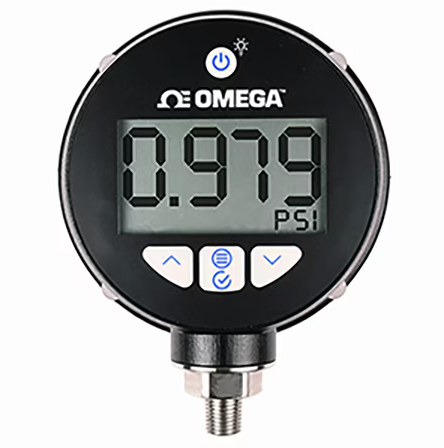

In [6]:
image

In [7]:
# Load model and tokenizer
model_id = "LiquidAI/LFM2-350M"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map={"": "cpu"},  # force CPU
    torch_dtype="float32",   # safer on CPU
)
tokenizer_llm = AutoTokenizer.from_pretrained(model_id)

# Generate answer
prompt = "What is the reading" + response 
input_ids = tokenizer_llm.apply_chat_template(
    [{"role": "user", "content": prompt}],
    add_generation_prompt=True,
    return_tensors="pt",
    tokenize=True,
).to(model.device)

output = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.3,
    min_p=0.15,
    repetition_penalty=1.05,
    max_new_tokens=512,
)

print(tokenizer_llm.decode(output[0], skip_special_tokens=False))

<|startoftext|><|im_start|>user
What is the readingThe gauge is a pressure gauge. The needle is pointing to 0.919. The unit of measurement is PSI (Pound-Sec).<|im_end|>
<|im_start|>assistant
The reading you've provided indicates that the gauge is a pressure gauge with a pressure reading of 0.919 PSI. This value represents the absolute pressure in pounds per square inch (PSI). In this context, it's commonly used to measure the absolute pressure in a system, such as the atmospheric pressure at sea level or in a specific industrial setting.

To put this into perspective:
- 1 PSI = approximately 7.48 psi
- 0.919 PSI is about 1.16 PSI lower than the standard atmospheric pressure at sea level (101.325 PSI).

This reading can be useful for various applications, including monitoring atmospheric conditions, measuring fluid pressures in pipelines, or ensuring the proper functioning of equipment under pressure.<|im_end|>
